#Evaluation

In [29]:
%matplotlib inline
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import numpy as np
import os
import time

### Load dataset

In [30]:
input_file_name = "lotOfFeatures.csv"
input_file_path = os.path.join(os.path.join(os.getcwd(), "data"), input_file_name)

original_data = pd.read_csv(input_file_path, index_col=0, parse_dates=True)
originalSize = original_data.shape[1]
original_data.head()
original_data.shape

(139678, 535)

## Excluding Testing Set

Spliting the dataset into three parts: training, testing and evaluation (last 10 percent).

In [31]:
start_time = '2012-02-01 00:00:00'
#start_time = '2014-02-01 00:00:00'
splitting_point = int(0.9 * original_data.shape[0])
splitting_time = original_data.iloc[[splitting_point]].index.to_pydatetime()[0]
#data = original_data[:splitting_time]
data = original_data[start_time:]

In [32]:
list(data)[:17]

['id14061671',
 'id14061684',
 'id14061709',
 'id14061716',
 'id14061685',
 'id14061674',
 'id14061721',
 'id14061680',
 'id14061714',
 'id11010024',
 'id11010019',
 'id14061707',
 'id11010017',
 'id14061677',
 'id11010020',
 'id14061729',
 'id12041022']

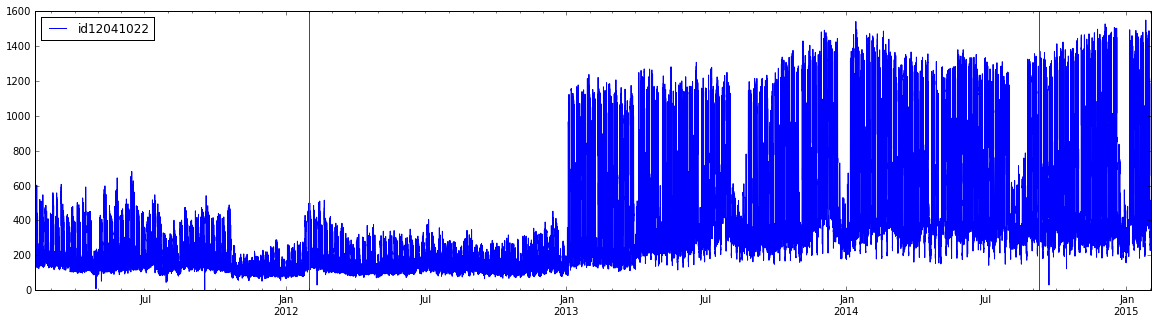

In [33]:
f = original_data[["id12041022"]].plot(figsize=(20,5)) 
original_data.iloc(splitting_point)
f.axvline(start_time, color='g')
f.axvline(splitting_time, color='r')

# Define Machine Learning Models and Data Sets

In [34]:
from sklearn import linear_model
from sklearn import cross_validation
from sklearn import svm
from sklearn import neighbors
from sklearn import metrics
import regression_metrics as additional_metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.learning_curve import learning_curve
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import explained_variance_score

## Creating Feature Sets

In [35]:
autoregressive_ftrs = ['measurement', 'measurement_1d', 'measurement_2d', 'measurement_1w', 
                       'measurement_roll_mean_1h', 'measurement_roll_mean_6h', 'measurement_roll_mean_d', 
                       'measurement_roll_mean_w', 'measurement_roll_mean_m', 'measurement_roll_min2_d',
                       'measurement_roll_min2_w', 'measurement_roll_max2_d', 'measurement_roll_max2_w',
                       'measurement_roll_var_6h', 'measurement_roll_var_d', 'measurement_roll_var_w']

wetaher_current_ftrs =  ['p', 't2m_termin', 'rh_termin', 'padavine', 'veter_hitrost', 'veter_vek_smer', 'energija_gl',
 'energija_di', 'p_roll_mean_1h', 'p_roll_mean_6h', 'p_roll_mean_d', 'p_roll_mean_w', 'p_roll_mean_m', 'p_roll_var_1h',
 'p_roll_var_d', 't2m_termin_roll_mean_1h', 't2m_termin_roll_mean_6h', 't2m_termin_roll_mean_d', 't2m_termin_roll_mean_w',
 't2m_termin_roll_mean_m', 't2m_termin_roll_min2_d', 't2m_termin_roll_min2_w', 't2m_termin_roll_max2_d',
 't2m_termin_roll_max2_w', 't2m_termin_roll_var_1h', 't2m_termin_roll_var_d', 'rh_termin_roll_mean_1h',
 'rh_termin_roll_mean_6h', 'rh_termin_roll_mean_d', 'rh_termin_roll_mean_w', 'rh_termin_roll_mean_m',
 'rh_termin_roll_min2_d', 'rh_termin_roll_min2_w', 'rh_termin_roll_max2_d', 'rh_termin_roll_max2_w',
 'rh_termin_roll_var_1h', 'rh_termin_roll_var_d', 'energija_gl_roll_mean_1h', 'energija_gl_roll_mean_6h',
 'energija_gl_roll_mean_d', 'energija_gl_roll_mean_w', 'energija_gl_roll_mean_m', 'energija_gl_roll_var_1h',
 'energija_gl_roll_var_d']

weather_forecasted_ftrs =  ['shifted_p', 'shifted_t2m_termin', 'shifted_rh_termin', 'shifted_padavine', 
                            'shifted_veter_hitrost', 'shifted_veter_vek_smer', 'shifted_energija_gl']

date_time_ftrs =  ['shifted_HourOfDay', 'shifted_DayOfWeek', 'shifted_Month', 'shifted_Weekday', 'shifted_Weekend', 
                   'shifted_Holiday', 'shifted_DayBeforeHoliday', 'shifted_DayAfterHodliay', 'shifted_BusinessDay', 
                   'shifted_BusinessDay_sum', 'shifted_Holiday_sum']

top20_ftrs = ['shifted_HourOfDay', 'measurement_roll_mean_6h', 'shifted_energija_gl', 'shifted_BusinessDay', 'measurement',
              'measurement_roll_mean_d', 'measurement_roll_mean_1h', 'measurement_roll_var_w', 'measurement_roll_max2_w',
              'measurement_roll_mean_w', 'shifted_DayOfWeek', 'energija_gl_roll_mean_6h', 'measurement_roll_var_6h', 
              't2m_termin_roll_mean_m', 'energija_gl_roll_mean_1h', 'shifted_t2m_termin', 'p_roll_var_d', 
              'measurement_roll_mean_m', 'energija_gl_roll_mean_m', 'energija_gl']

top10_ftrs = ['shifted_HourOfDay', 'measurement_roll_mean_6h', 'shifted_energija_gl', 'shifted_BusinessDay', 'measurement',
              'measurement_roll_mean_d', 'measurement_roll_mean_1h', 'measurement_roll_var_w', 'measurement_roll_max2_w',
              'measurement_roll_mean_w']

selected_ftrs = ['shifted_HourOfDay', 'measurement_roll_mean_6h', 'shifted_BusinessDay', 'measurement',
                 'measurement_roll_mean_d', 'measurement_roll_mean_1h', 'measurement_roll_var_w', 'measurement_roll_max2_w',
                 'measurement_roll_mean_w', 'shifted_DayOfWeek', 'measurement_roll_var_6h', 'measurement_roll_mean_m']

In [36]:
all_ftrs = autoregressive_ftrs + wetaher_current_ftrs + weather_forecasted_ftrs + date_time_ftrs 
ar_wc_wf_ftrs = autoregressive_ftrs + wetaher_current_ftrs + weather_forecasted_ftrs
ar_wc_dt_ftrs = autoregressive_ftrs + wetaher_current_ftrs + date_time_ftrs 
ar_wf_dt_ftrs = autoregressive_ftrs + weather_forecasted_ftrs + date_time_ftrs 
ar_dt_ftrs = autoregressive_ftrs + date_time_ftrs 
ar_ftrs = autoregressive_ftrs
top20_ftrs = top20_ftrs
top10_ftrs = top10_ftrs
seleceted_ftrs = selected_ftrs

## Prediction Results

In [111]:
test = data
test.columns
test["Test"] = test['id14061671']
average = test.groupby([test.index.dayofweek, test.index.time])['id14061671'].mean()
test = test.join(pd.DataFrame(average).rename(columns={"id14061671":"AvrFlow"}), 
                 on=[test.index.dayofweek, test.index.time], how = 'left')
test

C:\Python27\lib\site-packages\IPython\kernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,id14061671,id14061684,id14061709,id14061716,id14061685,id14061674,id14061721,id14061680,id14061714,id11010024,...,energija_gl_roll_mean_6h,energija_gl_roll_mean_d,energija_gl_roll_mean_w,energija_gl_roll_mean_m,energija_gl_roll_var_1h,energija_gl_roll_var_d,BusinessDay_sum,Holiday_sum,Test,AvrFlow
2012-02-01 00:00:00,0,0,47.0,14,30,15,9,3,0,0.0,...,0.00,48.536082,83.164933,63.463890,0.000,5882.438789,481,0,0,57.579618
2012-02-01 00:15:00,0,0,45.0,14,29,17,9,3,0,1.0,...,0.00,48.536082,83.164933,63.463890,0.000,5882.438789,481,0,0,55.847134
2012-02-01 00:30:00,0,0,40.0,14,34,18,8,3,0,0.0,...,0.00,48.536082,83.164933,63.463890,0.000,5882.438789,481,0,0,55.184713
2012-02-01 00:45:00,0,0,38.0,14,33,20,8,3,0,0.0,...,0.00,48.536082,83.164933,63.463890,0.000,5882.438789,481,0,0,55.057325
2012-02-01 01:00:00,0,0,36.0,14,33,19,9,3,0,1.0,...,0.00,48.536082,83.164933,63.463890,0.000,5882.438789,481,0,0,53.554140
2012-02-01 01:15:00,0,0,33.0,14,27,16,8,3,0,0.0,...,0.00,48.536082,83.164933,63.463890,0.000,5882.438789,481,0,0,52.891720
2012-02-01 01:30:00,0,0,34.0,15,27,16,9,3,0,0.0,...,0.00,48.536082,83.164933,63.463890,0.000,5882.438789,481,0,0,51.898089
2012-02-01 01:45:00,0,0,34.0,14,31,16,8,3,0,1.0,...,0.00,48.536082,83.164933,63.463890,0.000,5882.438789,481,0,0,52.535032
2012-02-01 02:00:00,0,0,33.0,14,32,16,8,2,0,0.0,...,0.00,48.536082,83.164933,63.463890,0.000,5882.438789,481,0,0,53.452229
2012-02-01 02:15:00,0,0,35.0,15,33,16,9,4,0,0.0,...,0.00,48.536082,83.164933,63.463890,0.000,5882.438789,481,0,0,89.681529


In [86]:
class NaiveModel:
    
    def __init__(self, target):
        self.target = target
        
    def fit(self, X_train,y_train):
        # No need to fit with naive models
        pass    

In [99]:
models = [{'name': "Baseline - Last value", 'init': "NaiveModel('measurement')"},
          {'name': "Baseline - Previous day", 'init': "NaiveModel('measurement_1d')"},
          {'name': "Baseline - Previous week", 'init': "NaiveModel('measurement_1w')"},
          {'name': "Baseline - Measurement average", 'init': "NaiveModel('measurement_avr')"},
          #TODO: Local Average
          {'name': "Ridge Regression", 'init': "linear_model.Ridge()"},
          {'name': "K Nearest Neighbors", 'init': "neighbors.KNeighborsRegressor(n_neighbors = 5)"},
          {'name': "Random Forest", 'init': "RandomForestRegressor(n_estimators = 100, min_samples_leaf = 10, n_jobs=8)"},
          #{'name': "SVR", 'init': "svm.SVR(kernel ='rbf', C = 10, gamma = .001)"},
          #{'name': "Neural Network", 'init': "PyBrainNN(hidden_size = 100, learningrate = 0.001, momentum = 0.1, maxEpochs=10)"},
          ]

data_sets = [{'name': "AR", 'ftrs': ar_ftrs},
             {'name': "AR_WC_WF", 'ftrs': ar_wc_wf_ftrs},
             {'name': "AR_DT", 'ftrs': ar_dt_ftrs},             
             #{'name': "AR_WC_DT", 'ftrs': ar_wc_dt_ftrs},
             #{'name': "AR_WF_DT", 'ftrs': ar_wf_dt_ftrs},    
             {'name': "ALL", 'ftrs': all_ftrs},
             {'name': "TOP_20", 'ftrs': top20_ftrs},
             #{'name': "TOP_10", 'ftrs': top10_ftrs},
             {'name': "SELECTED", 'ftrs': seleceted_ftrs},
             ]

error_metrics = [{'name': "R2 Score", 'short': "R2", 'function': metrics.r2_score},
                 #{'name': "Explained Variance Score", 'short': "EV", 'function': metrics.explained_variance_score},
                 {'name': "Mean Absolute Error", 'short': "MAE", 'function': metrics.mean_absolute_error},
                 #{'name': "Mean Squared Error", 'short': "MSE", 'function': metrics.mean_squared_error},
                 {'name': "Mean Absolute Percentage Error", 'short': "MAPE", 'function': additional_metrics.mean_absolute_percentage_error},
                 {'name': "Mean Absolute Scaled Error", 'short': "MASE", 'function': additional_metrics.mean_absolute_scaled_error}
                ]

#validation_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[],[]], names=['sensor', 'horizon', 'error metric']),
#                             columns=pd.MultiIndex.from_arrays([[],[]], names=['method', 'data set']))

validation_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[],[]], names=['horizon', 'dataset', 'model']),
                             columns=pd.MultiIndex.from_arrays([[],[]], names=['sensor', 'error metric'])) 

In [112]:
validation_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[],[]], names=['horizon', 'dataset', 'model']),
                             columns=pd.MultiIndex.from_arrays([[],[]], names=['sensor', 'error metric'])) 

def start_prediction_valuation(verbose=False):

    #sensor_list = list(data)[:15] # Sensor ids (30)
    #sensor_list = ['id14061721', 'id14061674', 'id14061709']
    #sensor_list = ['id14061721']
    sensor_list = ['id12041022']

    for sensor_name in sensor_list:
        print "Working with sensor: {}".format(sensor_name)

        # Create dataframe for specific sensor
        sensor_ftrs_to_drop = [col for col in list(data) if col.startswith('id') and not col.startswith(sensor_name)]
        sensor_data_ftrs = [col for col in list(data) if col not in sensor_ftrs_to_drop]
        sensor_data = data[sensor_data_ftrs]

        # Replace 'sensor id' column names with 'measurement'
        sensor_data.rename(columns=lambda col: col.replace(sensor_name, 'measurement') if sensor_name in col else col, inplace=True)

        # Compute localized average
        average = sensor_data.groupby([sensor_data.index.dayofweek, sensor_data.index.time])['measurement'].mean()
        sensor_data = sensor_data.join(pd.DataFrame(average).rename(columns={"measurement":"measurement_avr"}), 
                         on=[sensor_data.index.dayofweek, sensor_data.index.time], how = 'left')
        
        #for horizon in range (1,25):
        for horizon in range (1,2):

            # Prepare columns to shift
            columnsToShift = list(sensor_data)
            shiftedColumns = ["shifted_" + col for col in columnsToShift]

            # Shift columns
            start = time.time() # Start measuring time
            sensor_data[shiftedColumns] = sensor_data[columnsToShift].shift(-1 * horizon, freq='H')
            sensor_data.dropna(inplace=True)
            runtime = time.time() - start # Calculate runtime
            
            # Split Training and Testing set
            training_data = sensor_data[:splitting_time]
            testing_data = sensor_data[splitting_time:]
            
            # Create dummy feature vector for linear regression
            sensor_data_dummy = sensor_data.join(pd.get_dummies(sensor_data['shifted_HourOfDay'], 
                    prefix='dummy_shifted_HourOfDay').join(pd.get_dummies(sensor_data['shifted_DayOfWeek'], 
                    prefix='dummy_shifted_DayOfWeek').join(pd.get_dummies(sensor_data['shifted_Month'], 
                    prefix='dummy_shifted_Month'))))
            #sensor_data_dummy.dropna(inplace=True)
            dummy_ftrs = [col for col in list(sensor_data_dummy.columns) if col.startswith('dummy')]
            training_data_dummy = sensor_data_dummy[:splitting_time]
            testing_data_dummy = sensor_data_dummy[splitting_time:]

            if verbose: print "\n\t-->Prediction horizont: {}h. Shifting runtime: {:.2f}s".format(horizon, runtime)

            for data_set in data_sets:            
                # Create training vectors
                X_train = training_data[data_set['ftrs']].values
                y_train = training_data[["shifted_measurement"]].values.ravel()
                #print "Using dummy features:", X_train.shape
                
                # Create testing vectors
                X_test = testing_data[data_set['ftrs']].values
                y_test = testing_data[["shifted_measurement"]].values.ravel()
                #print "Using dummy features:", X_test.shape
                
                # Create dummy feature vector for linear regression
                if "shifted_HourOfDay" in data_set['ftrs']: 
                    X_train_dummy = training_data_dummy[data_set['ftrs'] + dummy_ftrs].values
                else: 
                    X_train_dummy = training_data_dummy[data_set['ftrs']].values
                y_train_dummy = training_data_dummy[["shifted_measurement"]].values.ravel()
                #print "Using dummy features:", X_train_dummy.shape

                if "shifted_HourOfDay" in data_set['ftrs']:
                    X_test_dummy = testing_data_dummy[data_set['ftrs'] + dummy_ftrs].values
                else:
                    X_test_dummy = testing_data_dummy[data_set['ftrs']].values    
                y_test_dummy = testing_data_dummy[["shifted_measurement"]].values.ravel()
                #print "Using dummy features: ", X_test_dummy.shape

                                                                     
                if verbose: print "\n\t\t-->Dataset: {}. X_train: {}, y_train: {}".format(data_set['name'], X_train.shape, y_train.shape)

                for model in models: 
                    # Initializing model
                    mdl = eval(model['init'])

                    # Model leraning
                    start = time.time() # Start measuring time
                    if model['name'] == "Ridge Regression":
                        mdl.fit(X_train_dummy, y_train_dummy)
                    else:
                        mdl.fit(X_train,y_train)
                    runtime = time.time() - start # Calculate runtime

                    if verbose: print "\t\t\t-->Training model: {}, runtime: {:.2f}s".format(model['name'], runtime)

                    for metric in error_metrics:
                        #print "\t-->Error metric: {}".format(metric['name'])
                        
                        if model['name'][0:8] == 'Baseline':
                            if metric['short'] == 'MASE':
                                error = metric['function'](y_train, training_data[["measurement"]].values.ravel(),
                                                           y_test, testing_data[mdl.target])
                            else:
                                error = metric['function'](y_test, testing_data[mdl.target])
                            
                        elif model['name'] == "Ridge Regression":
                            if metric['short'] == 'MASE':
                                error = metric['function'](y_train_dummy, training_data[["measurement"]].values.ravel(),
                                                           y_test_dummy, mdl.predict(X_test_dummy))
                            else:
                                error = metric['function'](y_test_dummy, mdl.predict(X_test_dummy))
                                
                        else: 
                            if metric['short'] == 'MASE':
                                error = metric['function'](y_train, training_data[["measurement"]].values.ravel(), 
                                                           y_test, mdl.predict(X_test))
                            else:
                                error = metric['function'](y_test, mdl.predict(X_test))
                                
                        #validation_df.loc[(sensor_name, horizon, metric['short']),(data_set['name'], model['name'])] = error
                        validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, metric['short'])] = error
                        
                        if verbose: print "\t\t\t\t-->{}: {:.3f}".format(metric['short'], error)

start_prediction_valuation(verbose=True)
#start_prediction_valuation(verbose=False)
#validation_df

Working with sensor: id12041022

	-->Prediction horizont: 1h. Shifting runtime: 3.57s

		-->Dataset: AR. X_train: (91345L, 16L), y_train: (91345L,)
			-->Training model: Baseline - Last value, runtime: 0.00s
				-->R2: 0.821
				-->MAE: 93.677
				-->MAPE: 14.697
				-->MASE: 1.561
			-->Training model: Baseline - Previous day, runtime: 0.00s
				-->R2: 0.179
				-->MAE: 225.157
				-->MAPE: 43.191
				-->MASE: 3.752
			-->Training model: Baseline - Previous week, runtime: 0.00s
				-->R2: 0.564
				-->MAE: 150.961
				-->MAPE: 26.530
				-->MASE: 2.516
			-->Training model: Baseline - Measurement average, runtime: 0.00s
				-->R2: 0.342
				-->MAE: 241.183
				-->MAPE: 33.872
				-->MASE: 4.019
			-->Training model: Ridge Regression, runtime: 0.02s
				-->R2: 0.849
				-->MAE: 96.426
				-->MAPE: 16.091
				-->MASE: 1.607
			-->Training model: K Nearest Neighbors, runtime: 0.20s
				-->R2: 0.459
				-->MAE: 200.367
				-->MAPE: 37.544
				-->MASE: 3.339
			-->Training model: Random Fo

In [17]:
output_file_name = "validationResults_id14061674.csv"
output_file_path = os.path.join(os.path.join(os.getcwd(), "data"), output_file_name)

#validation_df.to_csv(output_file_path)

## Entire Validation Dataset

In [ ]:
#validation_df = pd.read_csv(output_file_path, index_col=[0,1,2], header=[0,1])

In [113]:
validation_df

sensor                                          id12041022              \
error metric                                            R2         MAE   
horizon dataset  model                                                   
1       AR       Baseline - Last value            0.820878   93.677220   
                 Baseline - Previous day          0.178674  225.156646   
                 Baseline - Previous week         0.563694  150.961114   
                 Baseline - Measurement average   0.342408  241.182709   
                 Ridge Regression                 0.849042   96.425615   
                 K Nearest Neighbors              0.459365  200.367403   
                 Random Forest                    0.925599   68.404414   
        AR_WC_WF Baseline - Last value            0.820878   93.677220   
                 Baseline - Previous day          0.178674  225.156646   
                 Baseline - Previous week         0.563694  150.961114   
                 Baseline - Measurement average   0.342408  241.182709   
                 Ridge Regression                 0.851883   97.071902   
                 K Nearest Neighbors              0.434139  203.539308   
                 Random Forest                    0.920568   70.913633   
        AR_DT    Baseline - Last value            0.820878   93.677220   
                 Baseline - Previous day          0.178674  225.156646   
                 Baseline - Previous week         0.563694  150.961114   
                 Baseline - Measurement average   0.342408  241.182709   
                 Ridge Regression                 0.884809   87.428795   
                 K Nearest Neighbors              0.459432  200.360934   
                 Random Forest                    0.946254   56.667491   
        ALL      Baseline - Last value            0.820878   93.677220   
                 Baseline - Previous day          0.178674  225.156646   
                 Baseline - Previous week         0.563694  150.961114   
                 Baseline - Measurement average   0.342408  241.182709   
                 Ridge Regression                 0.885434   87.074113   
                 K Nearest Neighbors              0.434133  203.543088   
                 Random Forest                    0.942031   59.888220   
        TOP_20   Baseline - Last value            0.820878   93.677220   
                 Baseline - Previous day          0.178674  225.156646   
                 Baseline - Previous week         0.563694  150.961114   
                 Baseline - Measurement average   0.342408  241.182709   
                 Ridge Regression                 0.882657   87.366097   
                 K Nearest Neighbors              0.411105  218.448034   
                 Random Forest                    0.944924   58.380377   
        SELECTED Baseline - Last value            0.820878   93.677220   
                 Baseline - Previous day          0.178674  225.156646   
                 Baseline - Previous week         0.563694  150.961114   
                 Baseline - Measurement average   0.342408  241.182709   
                 Ridge Regression                 0.882517   87.488977   
                 K Nearest Neighbors              0.412457  218.475928   
                 Random Forest                    0.943642   57.596703   

sensor                                                                
error metric                                          MAPE      MASE  
horizon dataset  model                                                
1       AR       Baseline - Last value           14.697035  1.561170  
                 Baseline - Previous day         43.191394  3.752330  
                 Baseline - Previous week        26.529682  2.515830  
                 Baseline - Measurement average  33.872115  4.019411  
                 Ridge Regression                16.090742  1.606973  
                 K Nearest Neighbors             37.543812  3.339207  
                 Random Forest

### Error plots for different sensors and prediction horizons

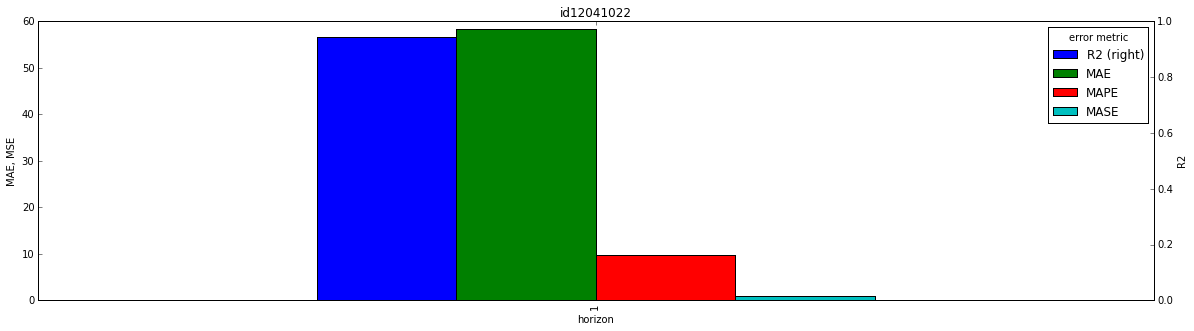

In [115]:
#num_of_graphs = len(validation_df.columns.levels[0])
#f, axx = plt.subplots(num_of_graphs, 1, sharey=True, sharex=True)
#f.set_size_inches(6*num_of_graphs,10)

for sensor_id in validation_df.columns.levels[0]:
    ax = validation_df.xs(("TOP_20", "Random Forest"), level=["dataset", "model"])[sensor_id].plot(
        kind='bar', secondary_y=['R2'], title=sensor_id, figsize=(20,5))
    ax.set_ylabel('MAE, MSE')
    ax.right_ax.set_ylabel('R2')

## Averaged Horizons Scores 

In [64]:
validation_df.groupby(level=['dataset', 'model']).mean()

sensor                       id14061671                           id14061684  \
error metric                         R2         MAE           MSE         R2   
dataset  model                                                                 
AR       Ridge Regression      0.460031  153.168088  40513.235220   0.272999   
         K Nearest Neighbors   0.078939  184.717368  69091.347799  -0.389616   
         Random Forest         0.650340  105.235671  26216.347702  -0.074523   
AR_WC_WF Ridge Regression      0.493762  148.666758  37978.728513   0.307212   
         K Nearest Neighbors   0.001652  193.075658  74886.023731  -0.889499   
         Random Forest         0.677111  105.105208  24213.508146  -0.185738   
AR_DT    Ridge Regression      0.652452  123.444163  26072.163732   0.408456   
         K Nearest Neighbors   0.073684  185.618849  69485.339471  -0.418295   
         Random Forest         0.863756   61.351433  10220.674737   0.473457   
AR_WC_DT Ridge Regression      0.654579  123.157654  25912.375320   0.401800   
         K Nearest Neighbors  -0.000002  193.254524  75009.972391  -0.884302   
         Random Forest         0.818683   72.847582  13602.693124   0.356171   
AR_WF_DT Ridge Regression      0.654313  123.247108  25932.596023   0.408262   
         K Nearest Neighbors   0.107746  181.513461  66926.181257  -0.401806   
         Random Forest         0.855729   63.167726  10823.106686   0.438741   
ALL      Ridge Regression      0.655290  123.013802  25858.934999   0.403227   
         K Nearest Neighbors   0.001675  193.072677  74884.273964  -0.892669   
         Random Forest         0.813431   73.588132  13997.383533   0.368047   
TOP_20   Ridge Regression      0.634825  126.673879  27396.209952   0.367154   
         K Nearest Neighbors   0.160494  175.129807  62973.208301  -0.380517   
         Random Forest         0.804363   73.856849  14670.818326   0.197210   
TOP_10   Ridge Regression      0.630094  127.628284  27750.951445   0.372259   
         K Nearest Neighbors   0.115233  171.634968  66376.296233  -0.290820   
         Random Forest         0.843065   64.774163  11769.017018   0.344181   
SELECTED Ridge Regression      0.633199  126.839345  27518.281504   0.369970   
         K Nearest Neighbors   0.063876  188.217866  70224.539866  -0.373210   
         Random Forest         0.844087   64.166031  11694.062911   0.362581   

sensor                                               id14061709             \
error metric                        MAE          MSE         R2        MAE   
dataset  model                                                               
AR       Ridge Regression     26.152500  1153.630153   0.536020  12.271479   
         K Nearest Neighbors  36.672768  2205.103717   0.360291  13.900203   
         Random Forest        32.002427  1706.058716   0.648891  10.376372   
AR_WC_WF Ridge Regression     25.531208  1099.397705   0.608514  11.292668   
         K Nearest Neighbors  43.819618  2998.185712   0.143839  16.446740   
         Random Forest        33.977070  1881.947598   0.696081   9.742839   
AR_DT    Ridge Regression     23.737929   938.715580   0.711351   9.613250   
         K Nearest Neighbors  36.988687  2250.730080   0.330158  14.304887   
         Random Forest        22.210701   835.468102   0.751278   8.771504   
AR_WC_DT Ridge Regression     23.858086   949.279565   0.711457   9.579492   
         K Nearest Neighbors  43.667213  2989.972130   0.102675  16.899599   
         Random Forest        24.433587  1021.599316   0.749774   8.812146   
AR_WF_DT Ridge Regression     23.737988   939.020949   0.709132   9.633249   
         K Nearest Neighbors  36.952580  2224.550600   0.345984  14.169974   
         Random Forest        22.657859   890.560418   0.755231   8.680063   
ALL      Ridge Regression     23.820938   947.010298   0.710210   9.603547   
         K Nearest Neighbors  43.824315  3003.216329   0.134749  16.528113   
         Random Forest        24.155846

In [65]:
validation_df.groupby(level=['dataset', 'model']).std()

sensor                       id14061671                          id14061684  \
error metric                         R2        MAE           MSE         R2   
dataset  model                                                                
AR       Ridge Regression      0.109232  24.090020   8229.819893   0.157890   
         K Nearest Neighbors   0.146085  18.297665  10921.046734   0.183592   
         Random Forest         0.125220  24.352337   9364.212333   0.327259   
AR_WC_WF Ridge Regression      0.097596  21.882250   7336.680464   0.144711   
         K Nearest Neighbors   0.137060  17.398325  10200.124912   0.088460   
         Random Forest         0.094492  21.068824   7065.261698   0.338088   
AR_DT    Ridge Regression      0.057507  15.836321   4313.480664   0.116374   
         K Nearest Neighbors   0.149195  18.763816  11154.016785   0.191283   
         Random Forest         0.027810   7.517121   2086.084861   0.080933   
AR_WC_DT Ridge Regression      0.056593  15.603192   4243.251025   0.118862   
         K Nearest Neighbors   0.137173  17.396308  10207.412895   0.086979   
         Random Forest         0.038110   9.937221   2862.687568   0.101722   
AR_WF_DT Ridge Regression      0.056843  15.759229   4263.828006   0.116378   
         K Nearest Neighbors   0.129373  17.130245   9624.242995   0.141159   
         Random Forest         0.029789   7.461380   2236.392167   0.077771   
ALL      Ridge Regression      0.056449  15.547529   4231.850121   0.118656   
         K Nearest Neighbors   0.137061  17.398472  10200.214179   0.086477   
         Random Forest         0.038054   9.830398   2860.619166   0.097202   
TOP_20   Ridge Regression      0.062114  17.259000   4670.719101   0.128291   
         K Nearest Neighbors   0.141432  18.310466  10576.615626   0.134438   
         Random Forest         0.058917  11.737283   4401.961701   0.179452   
TOP_10   Ridge Regression      0.060447  16.660142   4543.369059   0.124540   
         K Nearest Neighbors   0.150178  19.628070  11289.382511   0.271855   
         Random Forest         0.033320   7.856033   2480.661091   0.121902   
SELECTED Ridge Regression      0.062990  17.429588   4737.211143   0.126829   
         K Nearest Neighbors   0.173227  22.045214  12994.273408   0.251903   
         Random Forest         0.033711   7.858494   2518.149155   0.113233   

sensor                                             id14061709            \
error metric                       MAE         MSE         R2       MAE   
dataset  model                                                            
AR       Ridge Regression     3.320393  249.976150   0.124380  1.971413   
         K Nearest Neighbors  2.948311  290.759049   0.116314  1.273968   
         Random Forest        5.717313  522.039930   0.051602  0.820101   
AR_WC_WF Ridge Regression     3.105782  229.366558   0.071910  1.250245   
         K Nearest Neighbors  0.772384  136.816140   0.094813  0.935369   
         Random Forest        5.969270  536.642311   0.031953  0.544925   
AR_DT    Ridge Regression     2.793196  184.383280   0.026536  0.528909   
         K Nearest Neighbors  2.956872  303.957654   0.109187  1.168508   
         Random Forest        2.028499  127.728284   0.018466  0.357664   
AR_WC_DT Ridge Regression     2.808865  188.333077   0.026175  0.509763   
         K Nearest Neighbors  0.783491  135.262488   0.102663  1.012866   
         Random Forest        2.278579  160.832631   0.017697  0.320530   
AR_WF_DT Ridge Regression     2.786411  184.371381   0.027260  0.527718   
         K Nearest Neighbors  2.277807  224.713055   0.092019  1.019940   
         Random Forest        1.771521  122.703347   0.017226  0.321589   
ALL      Ridge Regression     2.802798  187.982803   0.026601  0.515014   
         K Nearest Neighbors  0.756027  133.608758   0.094055  0.920972   
         Random Forest        2.188199  153.714825   0.017738  0.321599   
TOP_20   Ridge Regression     2.991492  203.058220   0

In [66]:
validation_df.groupby(level=['dataset', 'model']).mean()['id14061721']

KeyError: 'id14061721'

In [30]:
validation_df.groupby(level=['dataset', 'model']).std()['id14061721']['R2'].unstack(0)

dataset,all_ftrs,m_dt_ftrs,m_ftrs,m_wc_dt_ftrs,m_wc_wf_ftrs,m_wf_dt_ftrs,top_20_ftrs
model,,,,,,,
K Nearest Neighbors,0.113098,0.089173,0.138588,0.198930,0.102062,0.065410,0.064483
Random Forest,0.028098,0.026560,0.071062,0.028496,0.036011,0.026137,0.025691
Ridge Regression,0.131504,0.147573,0.153678,0.134263,0.138949,0.142195,0.140460


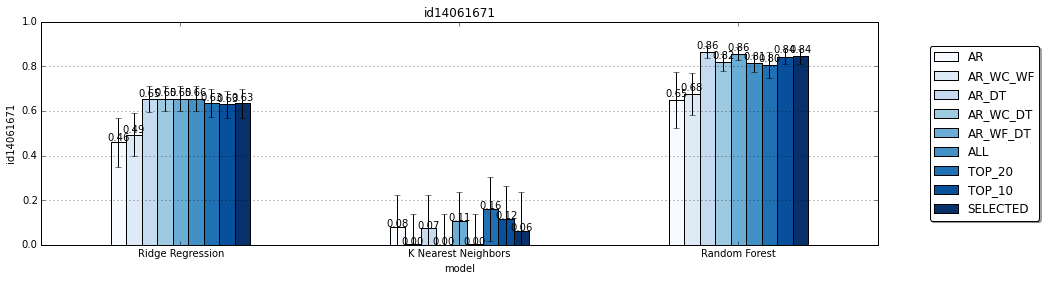

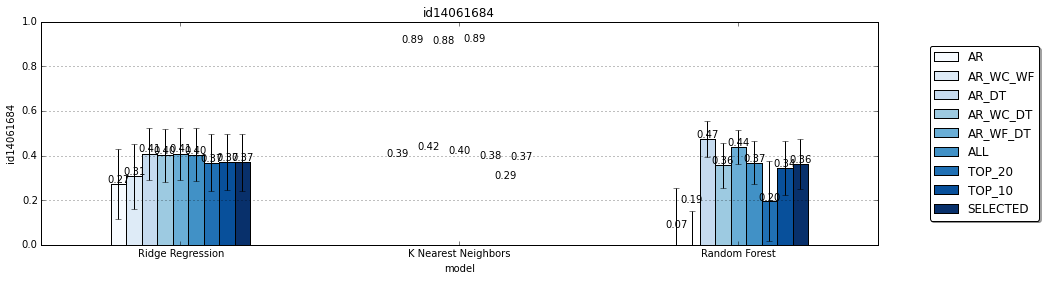

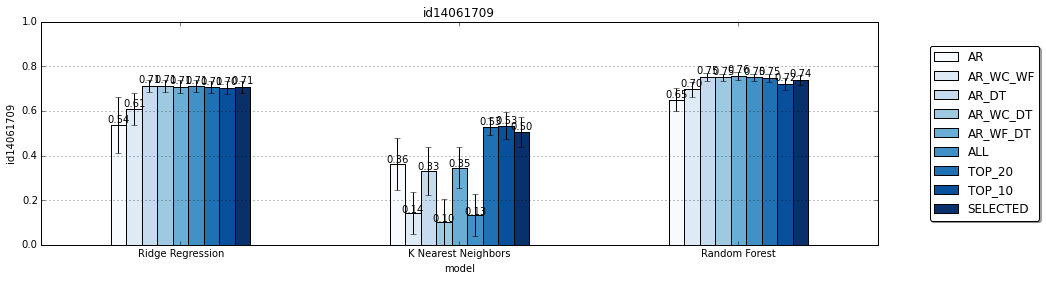

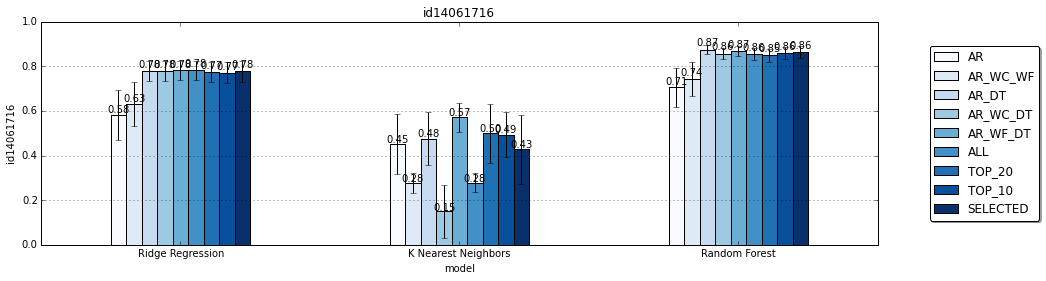

In [67]:
for sensor_id in validation_df.columns.levels[0]:
    
    err = validation_df.groupby(level=['dataset', 'model']).std()[sensor_id]['R2'].unstack(0)
    
    ax = validation_df.groupby(level=['dataset', 'model']).mean()[sensor_id]['R2'].unstack(0).plot(
        yerr=err, kind='bar', figsize=(15,4), rot=0, title=sensor_id, colormap='Blues', ylim=(0,1))
    
    for p in ax.patches:
        ax.annotate(str("%.2f" % p.get_height()), (p.get_x()+p.get_width()/2., p.get_height() * 1.02), fontsize=10, ha='center')
    
    plt.gca().yaxis.grid(True)
    ax.set_ylabel(sensor_id)
    plt.legend(loc='right', bbox_to_anchor=(1.2, 0.5), ncol=1, fancybox=True, shadow=True)

### Errors only for specific prediction horizon

In [388]:
"""
for sensor_id in validation_df.columns.levels[0]:
    ax = validation_df.loc[20][sensor_id]['R2'].unstack(0).plot(
        kind='bar', figsize=(15,4), rot=0, title=sensor_id, colormap='Blues', ylim=(0,1))
    
    for p in ax.patches:
        ax.annotate(str("%.2f" % p.get_height()), (p.get_x()+p.get_width()/2., p.get_height() * 1.02), fontsize=10, ha='center')
    
    plt.gca().yaxis.grid(True)
    ax.set_ylabel(measure)
    plt.legend(loc='right', bbox_to_anchor=(1.2, 0.5), ncol=1, fancybox=True, shadow=True)
"""

'\nfor sensor_id in validation_df.columns.levels[0]:\n    ax = validation_df.loc[20][sensor_id][\'R2\'].unstack(0).plot(\n        kind=\'bar\', figsize=(15,4), rot=0, title=sensor_id, colormap=\'Blues\', ylim=(0,1))\n    \n    for p in ax.patches:\n        ax.annotate(str("%.2f" % p.get_height()), (p.get_x()+p.get_width()/2., p.get_height() * 1.02), fontsize=10, ha=\'center\')\n    \n    plt.gca().yaxis.grid(True)\n    ax.set_ylabel(measure)\n    plt.legend(loc=\'right\', bbox_to_anchor=(1.2, 0.5), ncol=1, fancybox=True, shadow=True)\n'

## Averaged Scores by Sensors

In [199]:
validation_df.groupby(level='error metric', axis=1).mean()

error metric                                    R2       MAE         MSE
horizon dataset      model                                              
1       all_ftrs     Ridge Regression     0.944269  1.750940    8.856992
                     K Nearest Neighbors  0.066897  7.988847  177.344176
                     Random Forest        0.943590  1.748790    8.924401
        m_wc_wf_ftrs Ridge Regression     0.944166  1.757183    8.900042
                     K Nearest Neighbors  0.092666  7.919596  175.286799
                     Random Forest        0.943703  1.749920    8.923147
        m_wc_dt_ftrs Ridge Regression     0.944263  1.750683    8.853888
                     K Nearest Neighbors  0.091360  7.845368  171.064147
                     Random Forest        0.943689  1.746819    8.903057
        m_wf_dt_ftrs Ridge Regression     0.944120  1.751837    8.873416
                     K Nearest Neighbors  0.660034  4.426467   52.685557
                     Random Forest        0.944233  1.733138    8.796171
        m_dt_ftrs    Ridge Regression     0.944097  1.751904    8.875414
                     K Nearest Neighbors  0.804704  3.636148   39.212222
                     Random Forest        0.944349  1.730846    8.783673
        m_ftrs       Ridge Regression     0.943962  1.758596    8.922465
                     K Nearest Neighbors  0.872938  3.189027   30.275088
                     Random Forest        0.944133  1.736022    8.826751
        top_20_ftrs  Ridge Regression     0.944205  1.751554    8.861577
                     K Nearest Neighbors  0.776287  3.449343   32.858498
                     Random Forest        0.944374  1.729782    8.771622
2       all_ftrs     Ridge Regression     0.854188  3.063346   26.159467
                     K Nearest Neighbors  0.017433  8.365786  199.677958
                     Random Forest        0.887414  2.526949   17.601357
        m_wc_wf_ftrs Ridge Regression     0.853429  3.088932   26.321493
                     K Nearest Neighbors  0.025562  8.355834  200.024606
                     Random Forest        0.883615  2.544326   17.875777
        m_wc_dt_ftrs Ridge Regression     0.853540  3.060546   26.121296
                     K Nearest Neighbors  0.025626  8.330849  196.201980
                     Random Forest        0.887349  2.529629   17.729855
...                                            ...       ...         ...
23      m_dt_ftrs    Ridge Regression     0.637156  5.244161   70.547558
                     K Nearest Neighbors  0.507144  5.921202  103.638775
                     Random Forest        0.792980  3.574007   34.311882
        m_ftrs       Ridge Regression     0.605835  5.505930   78.981576
                     K Nearest Neighbors  0.529069  5.756699   96.320177
                     Random Forest        0.717986  4.272589   48.652980
        top_20_ftrs  Ridge Regression     0.642693  5.229665   69.153414
                     K Nearest Neighbors  0.559156  5.196304   71.374976
                     Random Forest        0.792090  3.535453   33.895403
24      all_ftrs     Ridge Regression     0.678104  4.744733   58.494166
                     K Nearest Neighbors -0.052645  8.581693  203.928692
                     Random Forest        0.764189  3.730448   38.630922
        m_wc_wf_ftrs Ridge Regression     0.647478  4.932747   63.396458
                     K Nearest Neighbors -0.012461  8.391388  191.624050
                     Random Forest        0.733352  4.165601   46.283397
        m_wc_dt_ftrs Ridge Regression     0.676321  4.756699   58.782008
                     K Nearest Neighbors -0.040585  8.505864  195.459819
                     Random Forest        0.761584  3.735215   38.703490
        m_wf_dt_ftrs Ridge Regression     0.666553  4.771114   60.030892
                     K Nearest Neighbors  0.428109  5.958527   98.381439
                     Random Forest        0.778846  3.606274   36.686329
        m_dt_ftrs    Ridge Regression     0.662670  4.7859

### Error plot for different prediction horizons and averaged errors by sensors

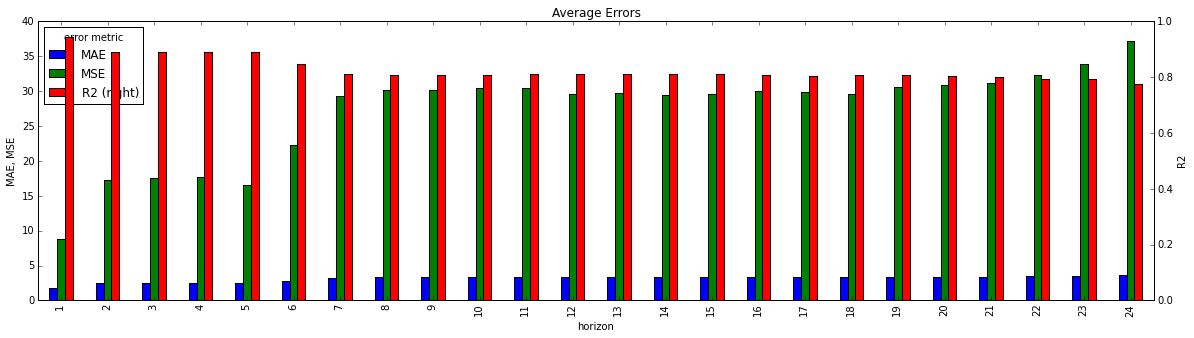

In [40]:
ax = validation_df.xs(("top_20_ftrs", "Random Forest"), level=["dataset", "model"]).groupby(
    level='error metric', axis=1).mean().plot(kind='bar', figsize=(20,5), secondary_y=['R2'], title="Average Errors")
ax.set_ylabel('MAE, MSE')
ax.right_ax.set_ylabel('R2')

## Average Score by Sensors and Horizons

In [70]:
validation_df.groupby(level=['dataset', 'model']).mean().groupby(level='error metric', axis=1).mean()

error metric                        R2        MAE           MSE
dataset  model                                                 
AR       Ridge Regression     0.462579  52.069420  10600.877892
         K Nearest Neighbors  0.125049  62.786934  18069.799385
         Random Forest        0.482660  39.755100   7113.245927
AR_WC_WF Ridge Regression     0.509606  50.275624   9930.131509
         K Nearest Neighbors -0.116841  68.296435  19796.309909
         Random Forest        0.482886  39.872278   6639.080224
AR_DT    Ridge Regression     0.638006  42.244531   6855.436051
         K Nearest Neighbors  0.115445  63.100004  18176.121847
         Random Forest        0.740797  24.894878   2833.590550
AR_WC_DT Ridge Regression     0.637011  42.195644   6817.984735
         K Nearest Neighbors -0.157980  68.981981  19867.963717
         Random Forest        0.695394  28.514201   3731.043985
AR_WF_DT Ridge Regression     0.638217  42.197730   6820.501427
         K Nearest Neighbors  0.155570  61.698406  17500.033228
         Random Forest        0.729721  25.525282   2999.072624
ALL      Ridge Regression     0.637612  42.150633   6803.777693
         K Nearest Neighbors -0.119643  68.315466  19798.023134
         Random Forest        0.696693  28.646940   3825.389762
TOP_20   Ridge Regression     0.620579  43.248407   7205.101574
         K Nearest Neighbors  0.202324  59.684485  16500.076570
         Random Forest        0.649973  29.498487   4063.528393
TOP_10   Ridge Regression     0.619717  43.506955   7292.699514
         K Nearest Neighbors  0.212902  58.544007  17316.544188
         Random Forest        0.691421  26.595288   3280.997984
SELECTED Ridge Regression     0.622300  43.254238   7233.263663
         K Nearest Neighbors  0.155655  63.215530  18334.489460
         Random Forest        0.701893  26.197264   3251.336471

In [69]:
validation_df.groupby(level=['dataset', 'model']).mean().groupby(level='error metric', axis=1).mean().unstack()

error metric               R2                                    \
model        Ridge Regression K Nearest Neighbors Random Forest   
dataset                                                           
AR                   0.462579            0.125049      0.482660   
AR_WC_WF             0.509606           -0.116841      0.482886   
AR_DT                0.638006            0.115445      0.740797   
AR_WC_DT             0.637011           -0.157980      0.695394   
AR_WF_DT             0.638217            0.155570      0.729721   
ALL                  0.637612           -0.119643      0.696693   
TOP_20               0.620579            0.202324      0.649973   
TOP_10               0.619717            0.212902      0.691421   
SELECTED             0.622300            0.155655      0.701893   

error metric              MAE                                    \
model        Ridge Regression K Nearest Neighbors Random Forest   
dataset                                                           
AR                  52.069420           62.786934     39.755100   
AR_WC_WF            50.275624           68.296435     39.872278   
AR_DT               42.244531           63.100004     24.894878   
AR_WC_DT            42.195644           68.981981     28.514201   
AR_WF_DT            42.197730           61.698406     25.525282   
ALL                 42.150633           68.315466     28.646940   
TOP_20              43.248407           59.684485     29.498487   
TOP_10              43.506955           58.544007     26.595288   
SELECTED            43.254238           63.215530     26.197264   

error metric              MSE                                    
model        Ridge Regression K Nearest Neighbors Random Forest  
dataset                                                          
AR               10600.877892        18069.799385   7113.245927  
AR_WC_WF          9930.131509        19796.309909   6639.080224  
AR_DT             6855.436051        18176.121847   2833.590550  
AR_WC_DT          6817.984735        19867.963717   3731.043985  
AR_WF_DT          6820.501427        17500.033228   2999.072624  
ALL               6803.777693        19798.023134   3825.389762  
TOP_20            7205.101574        16500.076570   4063.528393  
TOP_10            7292.699514        17316.544188   3280.997984  
SELECTED          7233.263663        18334.489460   3251.336471

In [156]:
#validation_df.loc[1,:, ['Ridge Regression','Random Forest']]

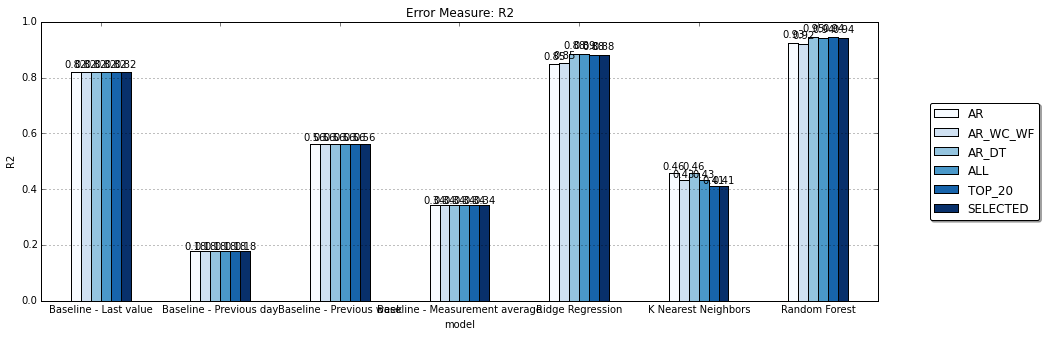

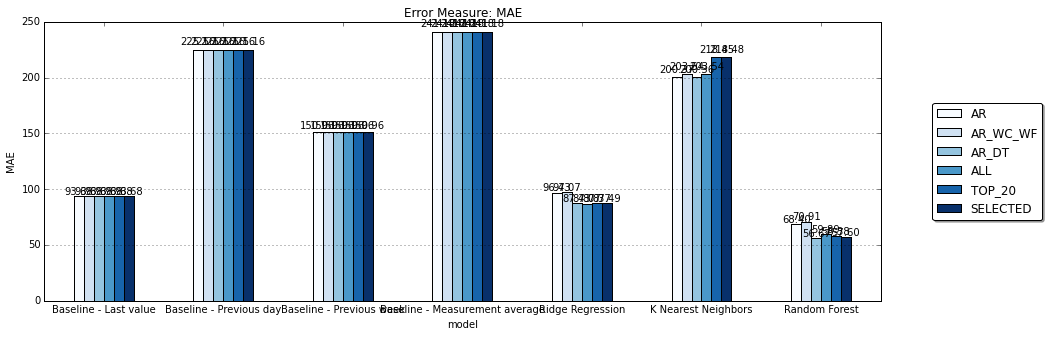

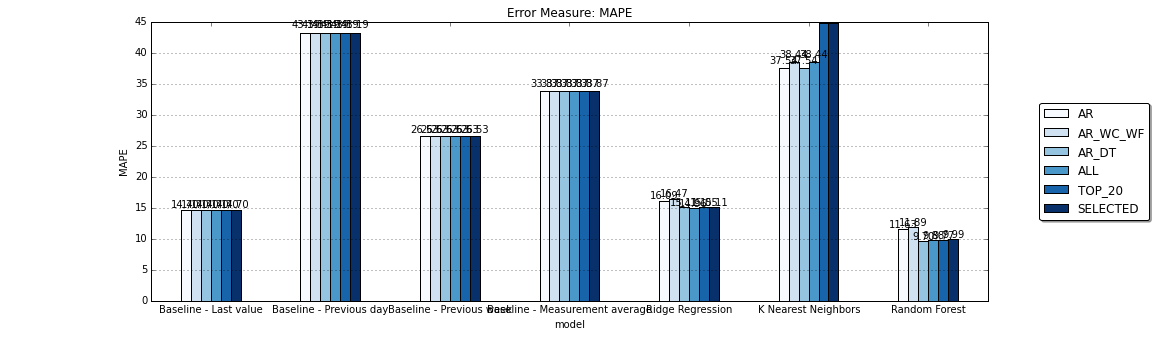

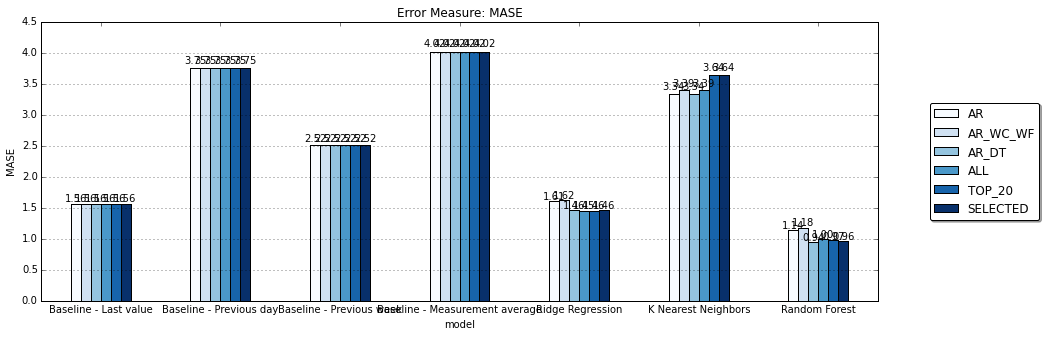

In [116]:
for measure in validation_df.columns.levels[1]:

    err = ax = validation_df.groupby(level=['dataset', 'model']).std().groupby(
        level='error metric', axis=1).mean()[measure].unstack(0)
    
    ax = validation_df.groupby(level=['dataset', 'model']).mean().groupby(
        level='error metric', axis=1).mean()[measure].unstack(0).plot(
        yerr=err, kind='bar', figsize=(15,5), rot=0, title="Error Measure: {}".format(measure), colormap='Blues')

    for p in ax.patches:
        ax.annotate(str("%.2f" % p.get_height()), (p.get_x()+p.get_width()/2., p.get_height() * 1.02), fontsize=10, ha='center')
    
    plt.gca().yaxis.grid(True)
    ax.set_ylabel(measure)
    plt.legend(loc='right', bbox_to_anchor=(1.2, 0.5), ncol=1, fancybox=True, shadow=True)

NOTE: From this, it looks like weather does not help to improve accuracy. Date time features are the most important.